In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import random
import tqdm
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors

In [2]:
from scipy.sparse import (
    SparseEfficiencyWarning,
    block_diag,
    csr_matrix,
    isspmatrix_csr,
    spmatrix,
)

In [3]:
import warnings

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
section_id = '151676'
parent_dir = 'data'
adata = sc.read_h5ad(os.path.join(parent_dir, section_id + ".h5ad"))

In [5]:
n_array_sum = adata.to_df().sum(1)

In [6]:
len(n_array_sum)

3460

In [7]:
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Non spatial

In [8]:
importlib.reload(simulation)

<module 'simulation' from '/Users/hs0424/Workspace/copulacci/src/copulacci/simulation.py'>

In [9]:
grid_points_df = simulation.create_param_grid()

In [26]:
grid_points_df.shape

(684, 5)

In [10]:
pseudo_count = simulation.sim_non_spatial(n_array_sum, grid_points_df)

684it [00:09, 69.29it/s] 


In [27]:
pseudo_count.shape

(3460, 1368)

In [11]:
data_list = []
i = 0
for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho, _ = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(i)].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(i)].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]
    i += 1

684it [00:00, 2986.29it/s]


In [12]:
opt_res = Parallel(n_jobs=20, verbose=1)(
            delayed(model.call_optimizer_dense)(
                x,
                y,
                _n_array,
                _n_array,
                method='Nelder-Mead',
                perm=20,
                DT=False,
                cutoff=0.8,
                num_restarts = 1
            ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   11.4s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   24.7s
[Parallel(n_jobs=20)]: Done 684 out of 684 | elapsed:   42.2s finished


In [13]:
importlib.reload(simulation)

<module 'simulation' from '/Users/hs0424/Workspace/copulacci/src/copulacci/simulation.py'>

In [14]:
importlib.reload(simulation)

<module 'simulation' from '/Users/hs0424/Workspace/copulacci/src/copulacci/simulation.py'>

In [15]:
res_df_melted, opt_res_df = simulation.prepare_df(
    opt_res,
    data_list,
    pseudo_count,
    grid_points_df,
    n_array_sum
)

684it [00:00, 5703.38it/s]
684it [00:00, 5762.42it/s]


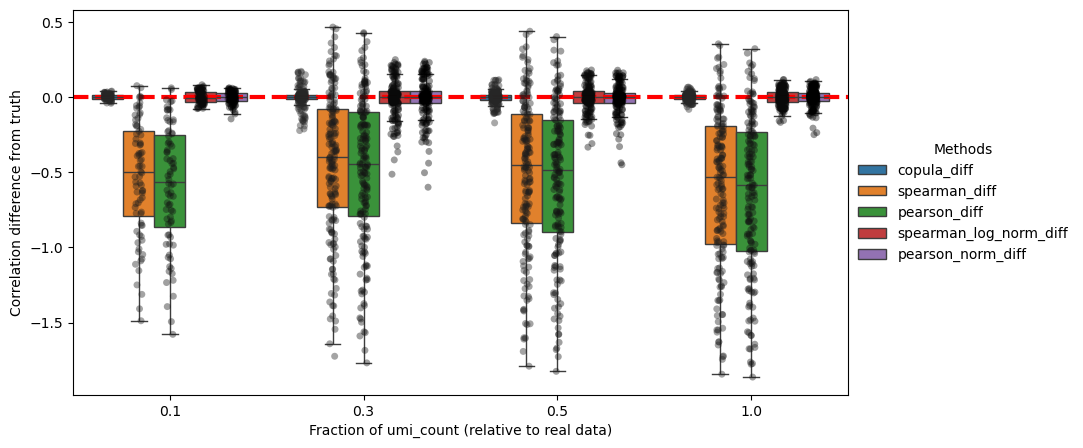

In [16]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

In [20]:
res_df_melted.zr_cat.unique()

['below_25', '75_100', '25_50', '50_75']
Categories (4, object): ['below_25' < '25_50' < '50_75' < '75_100']

In [24]:
figure_backup = "/Users/hs0424/Library/CloudStorage/GoogleDrive-hiraksarkar.cs@gmail.com/My Drive/Manuscripts/2023/Orator_copulacci/figures"

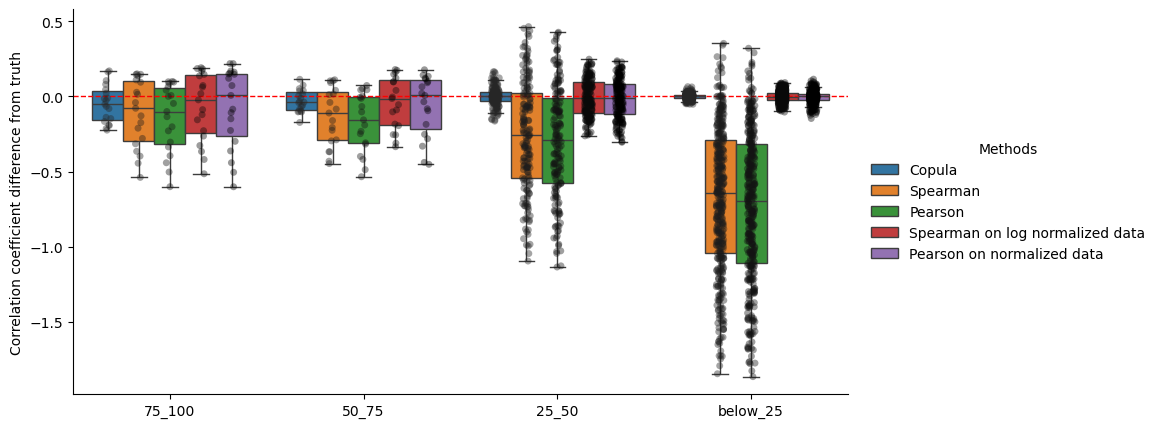

In [25]:
plt.figure(figsize=(10, 5))


#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,
              linewidth=0,
              edgecolor='gray',
             order = ['75_100', '50_75', '25_50', 'below_25'])

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0, 
            order = ['75_100', '50_75', '25_50', 'below_25']
           )

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(
    title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
plt.savefig( os.path.join(figure_backup,
                          'non_simulation_copula_10_19_reorder.pdf'), dpi = 300, bbox_inches='tight')
plt.show()

In [23]:
pwd

'/Users/hs0424/Workspace/copulacci/notebook/orator_paper_notebook'

In [17]:
res_df_melted.loc[ res_df_melted.rho < 0.0 , 'true_cor' ] = 'neg'
res_df_melted.loc[ res_df_melted.rho > 0.0 , 'true_cor' ] = 'pos'
res_df_melted.loc[ res_df_melted.rho == 0.0, 'true_cor' ] = 'zero'

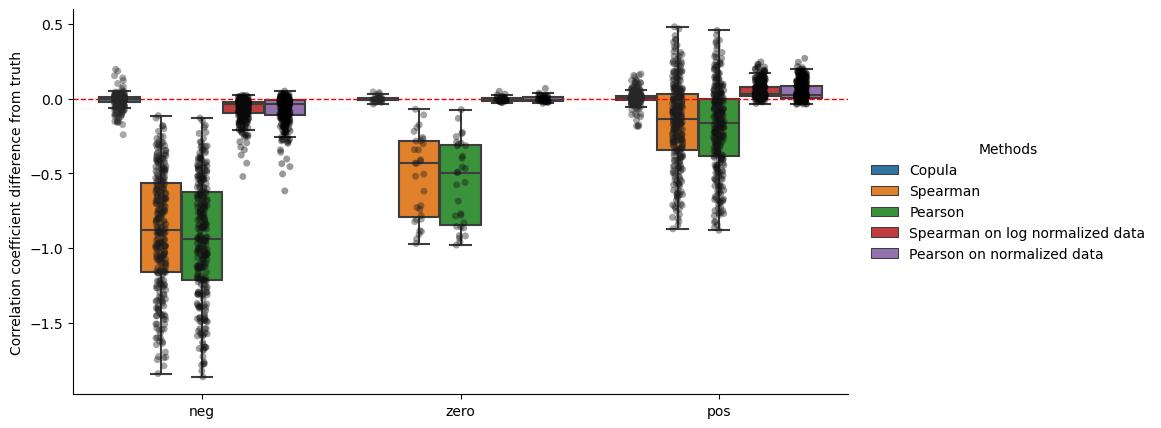

In [25]:
plt.figure(figsize=(10, 5))


#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="true_cor", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="true_cor", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
plt.savefig('figures/non_spatial_simulation_copula_diff_vs_dir_10_19.pdf', dpi = 300, bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------------------------------------

# Spatial Simulation with varying distance

In [19]:
importlib.reload(simulation)

<module 'simulation' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/simulation.py'>

In [20]:
grid_points_df = simulation.create_param_grid_spatial()

In [21]:
pos_w = simulation.create_spatial_grid()
sim_edge_list_df = simulation.sim_simple_spatial_distance(pos_w,100)

In [22]:
n_array_sum = np.array(random.sample(list(adata.to_df().sum(1)), sim_edge_list_df.shape[0]))

In [23]:
len(n_array_sum)

2000

In [24]:
pseudo_count = simulation.simulate_simple_spatial(n_array_sum, grid_points_df, sim_edge_list_df)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/py390/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/py390/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/py390/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both wil

In [26]:
data_list = []
i = 0
for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, _ = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(i)].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(i)].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]
    i += 1

1368it [00:00, 1998.68it/s]


In [27]:
opt_res = Parallel(n_jobs=20, verbose=1)(
        delayed(model.call_optimizer_dense_dist)(
        x,
        y,
        _n_array,
        _n_array,
        sim_edge_list_df.distance.values,
        method='Powell',
        perm=20,
        DT=False,
        cutoff=0.8,
        num_restarts = 1
        ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 530 tasks      | elapsed:   16.0s
[Parallel(n_jobs=20)]: Done 850 tasks      | elapsed:   26.2s
[Parallel(n_jobs=20)]: Done 1200 tasks      | elapsed:   40.7s
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:   47.4s finished


In [28]:
res_df_melted, opt_res_df = simulation.prepare_df_dist(
    opt_res,
    data_list,
    pseudo_count,
    grid_points_df,
    n_array_sum
)

1368it [00:00, 5122.51it/s]
1368it [00:00, 4942.43it/s]


In [36]:
opt_res_df

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind,pred_corr_zero,pred_corr_one,pred_mu_x,pred_mu_y,...,spearman_log_norm,pearson_norm,copula_diff,copula_one_diff,spearman_diff,pearson_diff,spearman_log_norm_diff,pearson_norm_diff,orig_index,method_diff
152,0.1,-5.0,-5.0,-0.9,0.01,152,-0.845941,0.008057,-5.000889,-4.998998,...,-0.665493,-0.614578,-0.054059,-0.908057,-0.779945,-0.852581,-0.234507,-0.285422,152,-0.725886
153,0.1,-5.0,-5.0,-0.9,0.05,153,-0.906519,0.054919,-5.003906,-4.974413,...,-0.295342,-0.286447,0.006519,-0.954919,-1.012167,-1.085530,-0.604658,-0.613553,153,-1.005648
154,0.1,-5.0,-5.0,-0.8,0.01,154,-0.759054,0.007030,-5.009209,-4.980079,...,-0.583492,-0.556689,-0.040946,-0.807030,-0.739566,-0.835131,-0.216508,-0.243311,154,-0.698620
155,0.1,-5.0,-5.0,-0.8,0.05,155,-0.813874,0.056348,-5.002081,-4.999375,...,-0.250228,-0.246972,0.013874,-0.856348,-0.953925,-1.041785,-0.549772,-0.553028,155,-0.940051
156,0.1,-5.0,-5.0,-0.7,0.01,156,-0.675420,0.007674,-5.005042,-4.982597,...,-0.518954,-0.508675,-0.024580,-0.707674,-0.679780,-0.751240,-0.181046,-0.191325,156,-0.655200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,1.0,-3.0,-3.0,0.7,0.05,1363,0.669525,0.044318,-2.997980,-2.999673,...,0.288516,0.300256,0.030475,0.655682,-0.276781,-0.285798,0.411484,0.399744,1363,-0.246306
1364,1.0,-3.0,-3.0,0.8,0.01,1364,0.789869,0.008933,-2.999844,-3.000885,...,0.641467,0.662431,0.010131,0.791067,-0.188930,-0.192947,0.158533,0.137569,1364,-0.178799
1365,1.0,-3.0,-3.0,0.8,0.05,1365,0.785723,0.046799,-2.998249,-3.000395,...,0.300365,0.302010,0.014277,0.753201,-0.177788,-0.186572,0.499635,0.497990,1365,-0.163512
1366,1.0,-3.0,-3.0,0.9,0.01,1366,0.898585,0.008872,-2.997989,-2.999140,...,0.728570,0.746710,0.001415,0.891128,-0.091807,-0.094818,0.171430,0.153290,1366,-0.090393


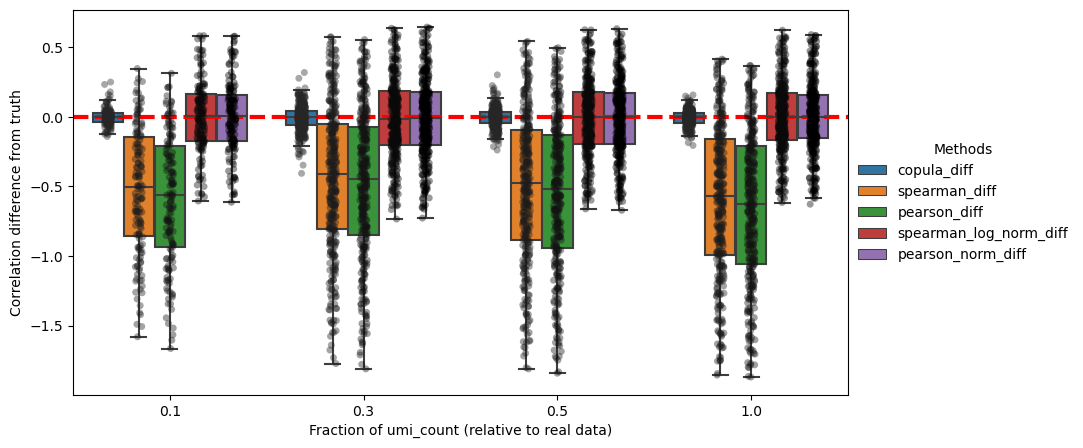

In [29]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

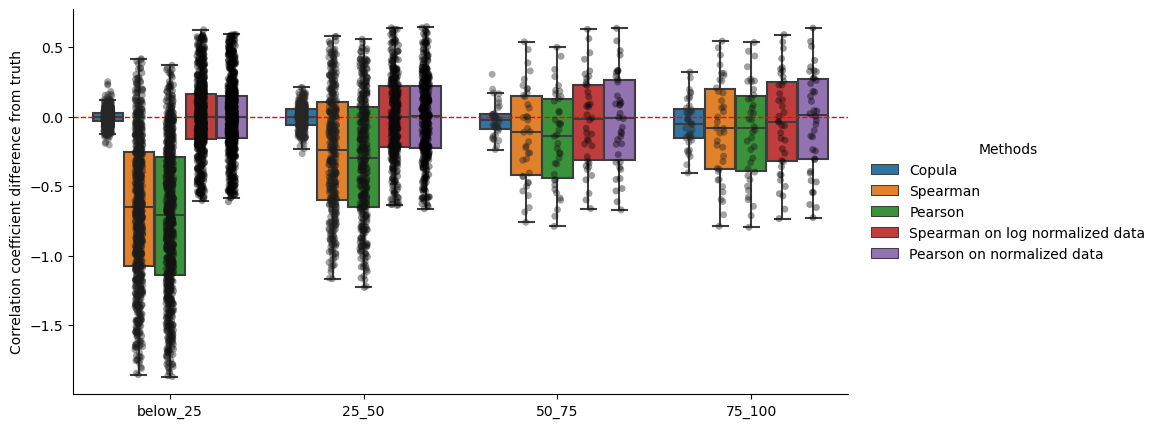

In [30]:
plt.figure(figsize=(10, 5))


#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
plt.savefig('figures/spatial_simulation_copula_10_19.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [34]:
res_df_melted.loc[ res_df_melted.rho_zero < 0.0 , 'true_cor' ] = 'neg'
res_df_melted.loc[ res_df_melted.rho_zero > 0.0 , 'true_cor' ] = 'pos'
res_df_melted.loc[ res_df_melted.rho_zero == 0.0, 'true_cor' ] = 'zero'

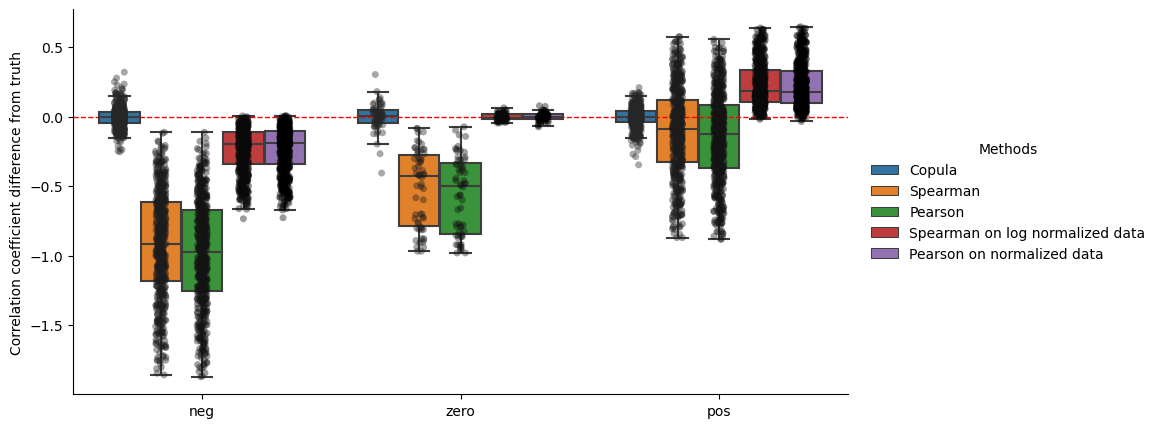

In [35]:
plt.figure(figsize=(10, 5))


#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="true_cor", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="true_cor", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
plt.savefig('figures/spatial_simulation_copula_diff_vs_dir_10_19.pdf', dpi = 300, bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------
# Spatial Simulation with varying distance with gradient

In [150]:
importlib.reload(simulation)

<module 'simulation' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/simulation.py'>

In [480]:
grid_points_df = simulation.create_param_grid_spatial()
pos_w = simulation.create_spatial_grid()
sim_edge_list_df = simulation.sim_simple_spatial_distance(pos_w,100)
n_array_sum = np.array(random.sample(list(adata.to_df().sum(1)), sim_edge_list_df.shape[0]))

In [481]:
pseudo_count = simulation.simulate_simple_grad_spatial(n_array_sum, grid_points_df, sim_edge_list_df)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/py390/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/py390/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/py390/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both wil

In [573]:
grid_points_df.loc[grid_points_df.rho_zero == 0]

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
18,0.1,-8.0,-8.0,0.0,0.01,18
19,0.1,-8.0,-8.0,0.0,0.05,19
56,0.1,-8.0,-5.0,0.0,0.01,56
57,0.1,-8.0,-5.0,0.0,0.05,57
94,0.1,-8.0,-3.0,0.0,0.01,94
...,...,...,...,...,...,...
1273,1.0,-3.0,-8.0,0.0,0.05,1273
1310,1.0,-3.0,-5.0,0.0,0.01,1310
1311,1.0,-3.0,-5.0,0.0,0.05,1311
1348,1.0,-3.0,-3.0,0.0,0.01,1348


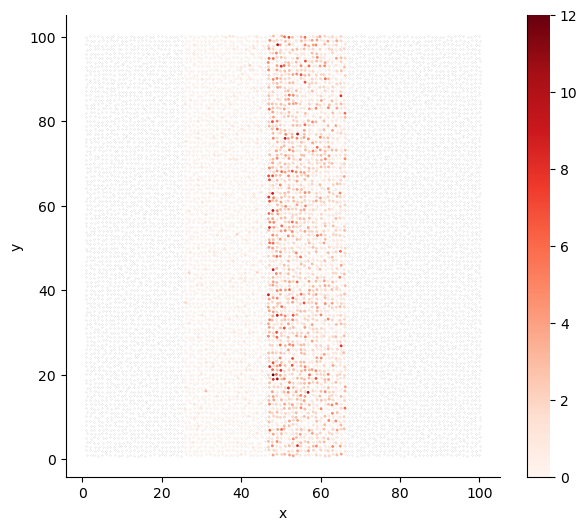

In [592]:
simulation.show_pattern(pos_w, sim_edge_list_df, pseudo_count, 57)

In [585]:
count_df_norm = pseudo_count.div(pseudo_count.sum(1), axis = 0) 
count_df_norm_log = np.log( count_df_norm + 1 )

data_list_norm = []

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, i = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list_norm += [
        (
            count_df_norm.loc[:, 'L'+str(int(i))],
            count_df_norm.loc[:, 'R'+str(int(i))]
        )
    ]
    i += 1

data_list_log = []

for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, i = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list_log += [
        (
            count_df_norm_log.loc[:, 'L'+str(int(i))],
            count_df_norm_log.loc[:, 'R'+str(int(i))]
        )
    ]

1368it [00:00, 5209.18it/s]
1368it [00:00, 5086.27it/s]


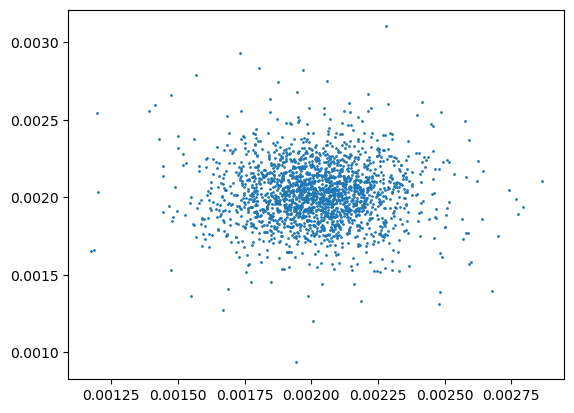

In [586]:
plt.scatter(data_list_norm[1348][0],data_list_norm[1348][1],s=1)

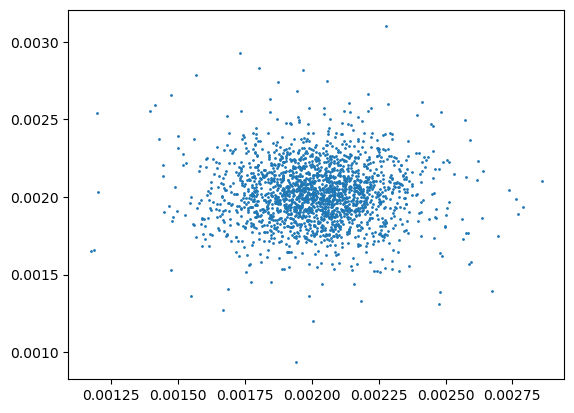

In [587]:
plt.scatter(data_list_log[1348][0],data_list_log[1348][1],s=1)

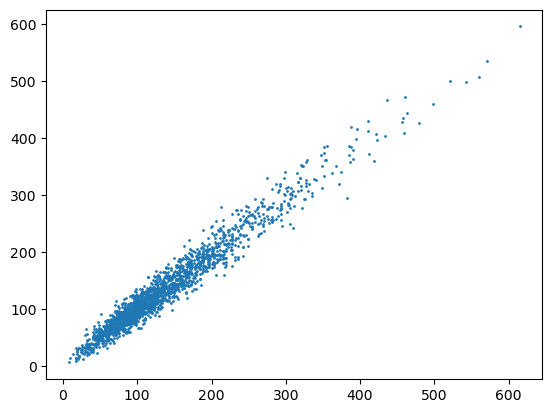

In [582]:
plt.scatter(data_list[1348][0],data_list[1348][1],s=1)

In [578]:
data_list = []
i = 0
for row in tqdm.tqdm(grid_points_df.iterrows()):
    sparse_frac, mu_x, mu_y, rho_zero, rho_one, _ = row[1]
    _n_array = (n_array_sum * sparse_frac).astype('int')
    data_list += [
        (
            pseudo_count.loc[:, 'L'+str(i)].values.astype('int'),
            pseudo_count.loc[:, 'R'+str(i)].values.astype('int'),
            mu_x, mu_y,
            _n_array.copy()
            
        )
    ]
    i += 1

1368it [00:00, 3662.41it/s]


In [172]:
opt_res = Parallel(n_jobs=20, verbose=1)(
            delayed(model.call_optimizer_dense_grad)(
        x,
        y,
        _n_array,
        _n_array,
        sim_edge_list_df.distance.values,
        sim_edge_list_df.gap.values,
        method='Powell',
        perm=20,
        DT=False,
        cutoff=0.8,
        num_restarts = 1
        ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 537 tasks      | elapsed:   49.6s
[Parallel(n_jobs=20)]: Done 843 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 1200 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:  2.8min finished


In [173]:
res_df_melted, opt_res_df = simulation.prepare_df_grad(
    opt_res,
    data_list,
    pseudo_count,
    grid_points_df,
    n_array_sum
)

1368it [00:00, 4748.95it/s]
1368it [00:00, 4640.88it/s]


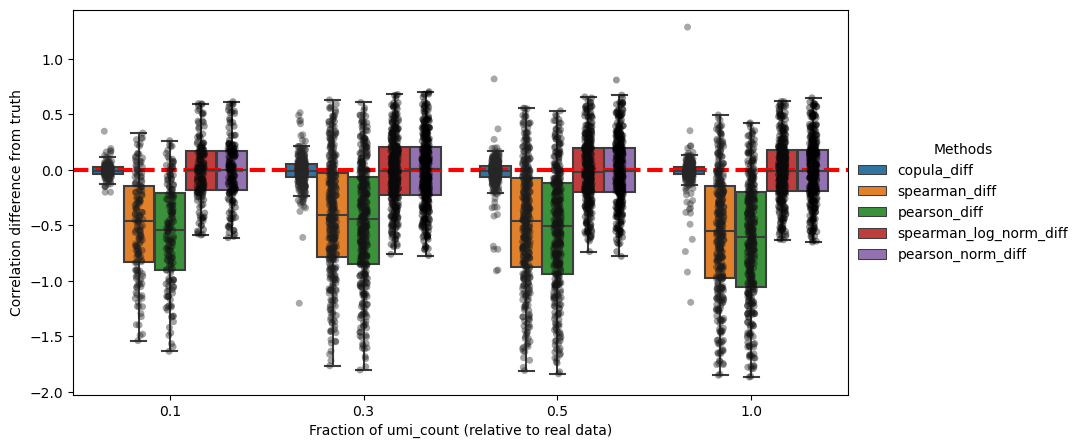

In [174]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

## Without marginal gradient model

In [175]:
opt_res_norm = Parallel(n_jobs=20, verbose=1)(
        delayed(model.call_optimizer_dense_dist)(
        x,
        y,
        pseudo_count.sum(1).values,
        pseudo_count.sum(1).values,
        sim_edge_list_df.distance.values,
        method='Powell',
        perm=20,
        DT=False,
        cutoff=0.8,
        num_restarts = 1
        ) for (x,y,_,_,_n_array) in data_list)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 201 tasks      | elapsed:   16.4s
[Parallel(n_jobs=20)]: Done 451 tasks      | elapsed:   34.6s
[Parallel(n_jobs=20)]: Done 801 tasks      | elapsed:   58.7s
[Parallel(n_jobs=20)]: Done 1251 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 1368 out of 1368 | elapsed:  1.7min finished


In [176]:
res_df_melted, opt_res_df = simulation.prepare_df_dist(
    opt_res_norm,
    data_list,
    pseudo_count,
    grid_points_df,
    n_array_sum
)

1368it [00:00, 4961.12it/s]
1368it [00:00, 5036.21it/s]


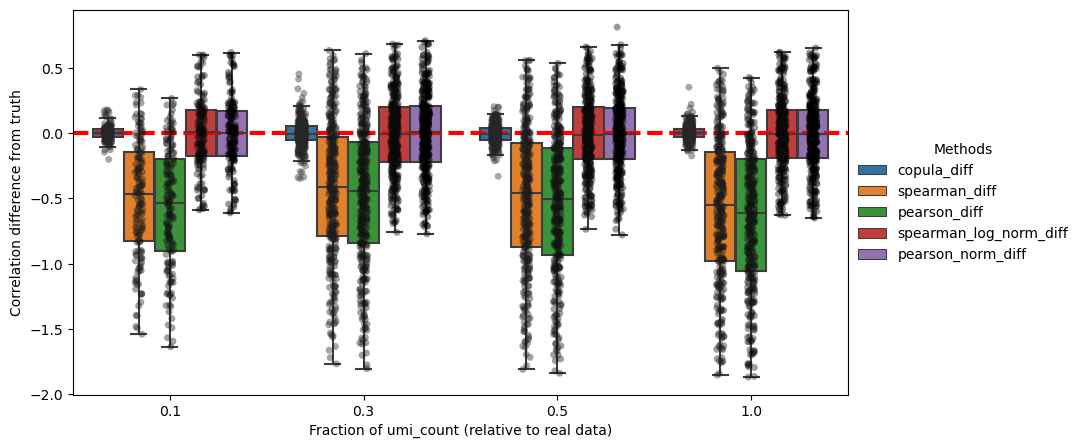

In [177]:
plt.figure(figsize=(10, 5))
sns.stripplot(x="sparse_frac", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="sparse_frac", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('Fraction of umi_count (relative to real data)', fontsize = 10)
plt.ylabel('Correlation difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 3, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", loc='right', bbox_to_anchor=(1.3,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')

plt.show()

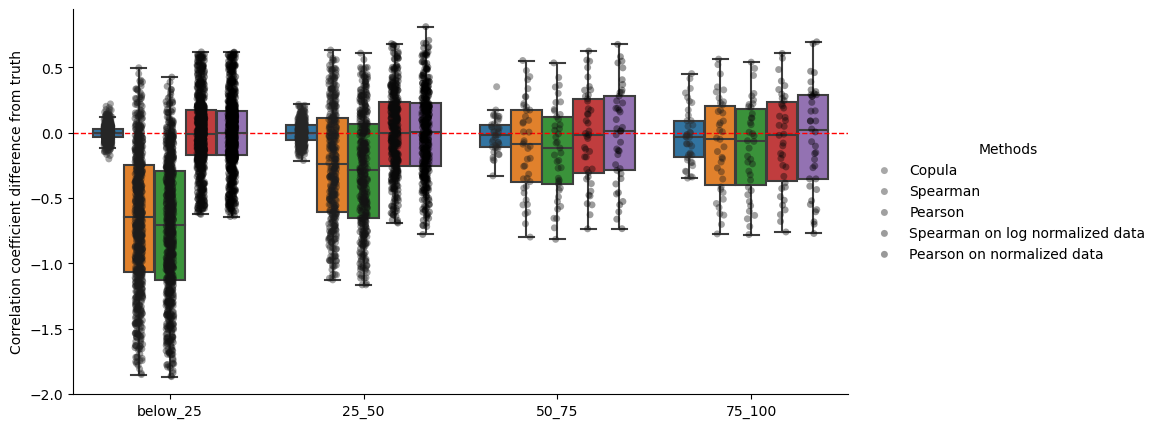

In [539]:
plt.figure(figsize=(10, 5))
#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')
#plt.legend(title="Legend", bbox_to_anchor=(1, 1), loc='upper left');
leg = plt.legend(title="Methods", 
                 labels = [label_dict[l.get_text()] for l in plt.gca().get_legend().get_texts()],
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);
plt.setp(leg.texts, fontsize='10')
sns.despine()
plt.show()

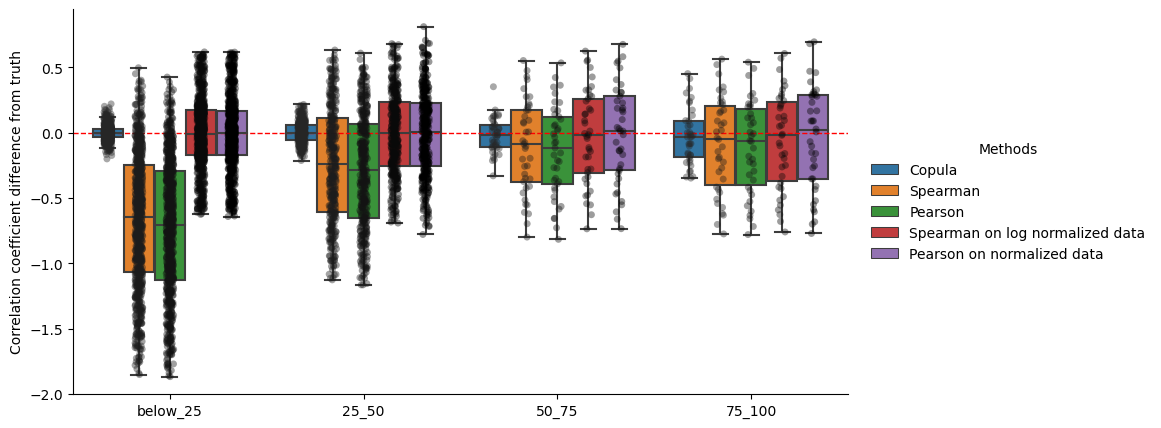

In [547]:


plt.figure(figsize=(10, 5))


#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="zr_cat", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="zr_cat", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
plt.savefig('figures/spatial_gradient_simulation_copula_10_18.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [564]:
res_df_melted.loc[ res_df_melted.rho_zero < 0.0 , 'true_cor' ] = 'neg'
res_df_melted.loc[ res_df_melted.rho_zero > 0.0 , 'true_cor' ] = 'pos'
res_df_melted.loc[ res_df_melted.rho_zero == 0.0, 'true_cor' ] = 'zero'

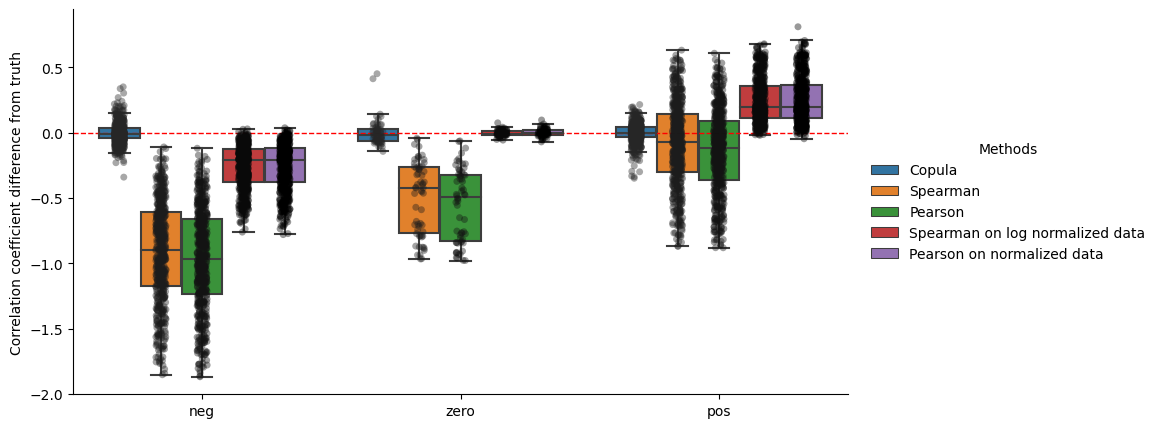

In [566]:
plt.figure(figsize=(10, 5))


#tmp = res_df_melted.loc[res_df_melted.method.isin(['copula_diff', 'spearman_norm_diff', 'spearman_log_norm_diff'])]
label_dict = { 'copula_diff' : 'Copula', 'spearman_diff': 'Spearman', 'pearson_diff' : 'Pearson', 
              'spearman_log_norm_diff': 'Spearman on log normalized data',
              'pearson_norm_diff' : 'Pearson on normalized data'}
sns.stripplot(x="true_cor", y="difference", hue="method",
              data=res_df_melted ,
              jitter=True,
              palette='dark:black',
              legend = None,
              #palette="Set5", 
              alpha = 0.4,
              dodge=True,linewidth=0,edgecolor='gray')

sns.boxplot(x="true_cor", y="difference", hue="method",
            data=res_df_melted,
            #palette="Set5",
            fliersize=0)

plt.xlabel('', fontsize = 10)
plt.ylabel('Correlation coefficient difference from truth', fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axhline(y=0, c = 'r', linewidth = 1, linestyle='--')


#leg = plt.gca().get_legend()
leg = plt.legend(title="Methods",
                 loc='right', bbox_to_anchor=(1.4,0.5),
          frameon=False);

# Replace the legend labels using the custom handler
for text, handle in zip(leg.texts, leg.legend_handles):
    text.set_text(label_dict.get(text.get_text(), text.get_text()))

plt.setp(leg.texts, fontsize='10')
sns.despine()
#plt.savefig('figures/spatial_gradient_simulation_copula_10_18.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [548]:
!pwd

/n/fs/ragr-research/users/hirak/Projects/niche_project/COMMOT_paper_data/orator_paper_notebook


In [196]:
importlib.reload(simulation)

<module 'simulation' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/simulation.py'>

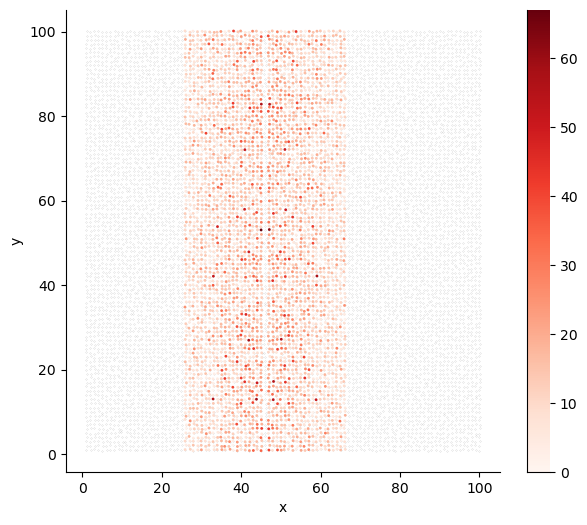

In [197]:
simulation.show_pattern(pos_w, sim_edge_list_df, pseudo_count, 340)

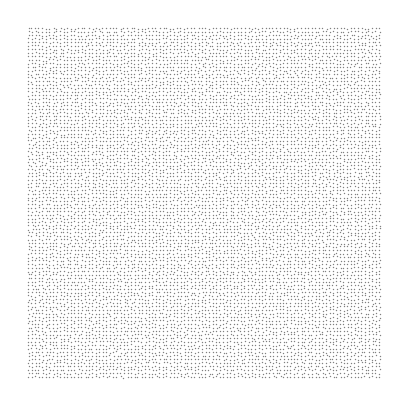

In [425]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pos_w.x, pos_w.y,s=1,alpha=1,linewidth=0,color='grey');
plt.axis('off');

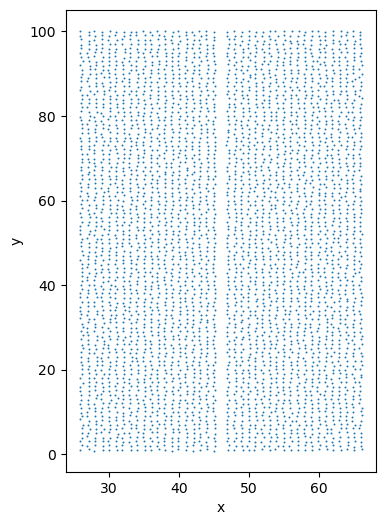

In [418]:
fig, ax = plt.subplots(figsize=(4, 6))

i = 340
tmp_source = pos_w.iloc[sim_edge_list_df.source,:].copy()
#tmp_source.loc[:,'gene'] = pseudo_count.loc[:, 'L' + str(i)].values
tmp_source.loc[:,'celltype'] = 'ligand'
tmp_end = pos_w.iloc[sim_edge_list_df.target,:].copy()
#tmp_end.loc[:,'gene'] = pseudo_count.loc[:, 'R' + str(i)].values
tmp_end.loc[:,'celltype'] = 'receptor'
tmp_dist = pd.concat([tmp_source, tmp_end])
sns.scatterplot(data= tmp_dist, x="x", y="y",
                s=2, linewidth=0, alpha=1,ax =ax);

In [412]:
tmp_dist

,x,y,celltype
cell2501,25.863944,1.077361,ligand
cell2502,26.058460,2.156867,ligand
cell2503,25.842508,3.096579,ligand
cell2504,26.149282,3.865987,ligand
cell2505,26.042426,5.024847,ligand
...,...,...,...
cell4696,47.012199,96.128620,receptor
cell4697,47.140095,97.045287,receptor
cell4698,47.097599,98.179683,receptor
cell4699,46.806966,98.977437,receptor


## Spatial simulation with TP/FP setting

Create a set of 200 pairs of ligands and receptors from real spot pairs. Divide the grid into block of 10
x 10, and then select independent edges from them. 

In [317]:
grid_points = pos_w.copy()

In [324]:
nop = 100
N = nop ** 2

# Generate positions
pos = np.array(np.meshgrid(np.arange(0, int(np.sqrt(N)) ), 
                        np.arange(0, int(np.sqrt(N))))).T.reshape(-1, 2)
pos = np.concatenate((pos, pos[::-1]), axis=0)
pos = np.unique(pos, axis=0)
pos_names = [f'cell{i+1}' for i in range(N)]
df_pos = pd.DataFrame(pos, columns=['x', 'y'])
df_pos.index = pos_names

In [345]:
rand_list = random.sample(list(range(100)),100)

In [348]:
grid_dict = {}

for grid_x in range(10):
    for grid_y in range(10):
        grid_dict[f"{grid_x}{grid_y}"] = rand_list[grid_x*10 + grid_y]

In [350]:
import hashlib
def calculate_block(x, y, grid_size=10):
    block_x = x // grid_size
    block_y = y // grid_size

    return(rand_list[block_x*10 + block_y])
    #return (int(block_x * grid_size + block_y))
    #return (block_x, block_y)

In [351]:
df_pos['block'] = df_pos.apply(lambda row : calculate_block(row['x'], row['y'] ), axis = 1)

In [352]:
grid_points['block'] = df_pos['block']

In [427]:
grid_dict['00'], grid_dict['01'], grid_dict['10'], grid_dict['11']

(35, 3, 16, 81)

/tmp/ipykernel_3223079/764541632.py:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = ax.figure.colorbar(sm)


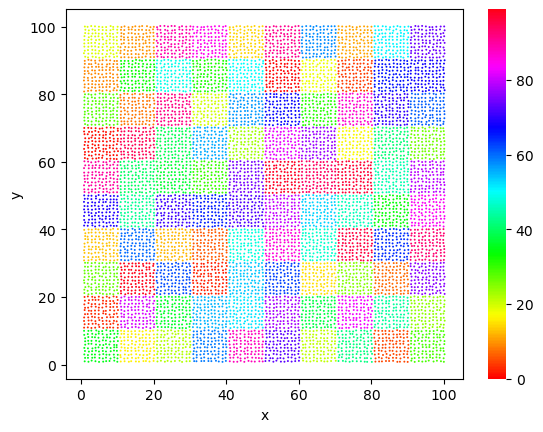

In [356]:
ax = sns.scatterplot(data = grid_points, x = 'x', y = 'y', hue = 'block', s = 2, 
                linewidth = 0, palette = 'hsv')
norm = plt.Normalize(grid_points['block'].min(), grid_points['block'].max())
sm = plt.cm.ScalarMappable(cmap="hsv",norm=norm)
sm.set_array([])
ax.get_legend().remove()
cbar = ax.figure.colorbar(sm)
cbar.outline.set_linewidth(0)

In [361]:
for block in grid_points.block.unique():
    df_tmp = grid_points.loc[ grid_points.block.isin([35, 3, 16, 81]) ].copy()
    break

In [434]:
[grid_dict[k] for k in ['33','34','35','43','44','45','53','54','55']]

[6, 65, 30, 48, 72, 75, 86, 80, 98]

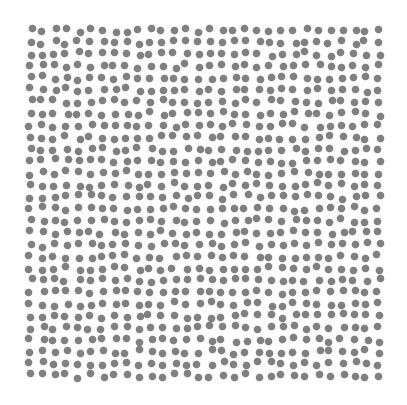

In [558]:
fig, ax = plt.subplots(figsize=(5, 5))
df_tmp = grid_points.loc[ grid_points.block.isin([grid_dict[k] for k in ['33','34','35','43','44','45','53','54','55']]) ].copy()
ax.scatter(df_tmp.x, df_tmp.y,s=30,alpha=1,linewidth=0,color='grey');
plt.axis('off');

In [524]:
grid_points_df.loc[ 
    ((grid_points_df.sparse_frac == 0.1) &
    (grid_points_df.mu_x == -3))

]

,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
228,0.1,-3.0,-8.0,-0.9,0.01,228
229,0.1,-3.0,-8.0,-0.9,0.05,229
230,0.1,-3.0,-8.0,-0.8,0.01,230
231,0.1,-3.0,-8.0,-0.8,0.05,231
232,0.1,-3.0,-8.0,-0.7,0.01,232
...,...,...,...,...,...,...
337,0.1,-3.0,-3.0,0.7,0.05,337
338,0.1,-3.0,-3.0,0.8,0.01,338
339,0.1,-3.0,-3.0,0.8,0.05,339
340,0.1,-3.0,-3.0,0.9,0.01,340


,sparse_frac,mu_x,mu_y,rho_zero,rho_one,ind
0,0.1,-8.0,-8.0,-0.9,0.01,0
1,0.1,-8.0,-8.0,-0.9,0.05,1
2,0.1,-8.0,-8.0,-0.8,0.01,2
3,0.1,-8.0,-8.0,-0.8,0.05,3
4,0.1,-8.0,-8.0,-0.7,0.01,4
...,...,...,...,...,...,...
1363,1.0,-3.0,-3.0,0.7,0.05,1363
1364,1.0,-3.0,-3.0,0.8,0.01,1364
1365,1.0,-3.0,-3.0,0.8,0.05,1365
1366,1.0,-3.0,-3.0,0.9,0.01,1366


In [525]:
i = 337

s = pos_w.iloc[sim_edge_list_df.source].copy()
s.loc[:, 'gene'] = pseudo_count.loc[:, 'L' + str(i)].values
t = pos_w.iloc[sim_edge_list_df.target].copy()
t.loc[:, 'gene'] = pseudo_count.loc[:, 'R' + str(i)].values

In [526]:
tmp_source = df_tmp.loc[list(
    set(s.index).intersection(
    set(df_tmp.index)
))].copy()
tmp_source.loc[:,'celltype'] = 'ligand'
tmp_source.loc[:, 'gene'] = s.loc[ tmp_source.index, 'gene' ] 
tmp_end = df_tmp.loc[list(
    set(t.index).intersection(
    set(df_tmp.index)
))].copy()
tmp_end.loc[:,'celltype'] = 'receptor'
tmp_end.loc[:, 'gene'] = t.loc[ tmp_end.index, 'gene' ] 
tmp_dist = pd.concat([tmp_source, tmp_end])

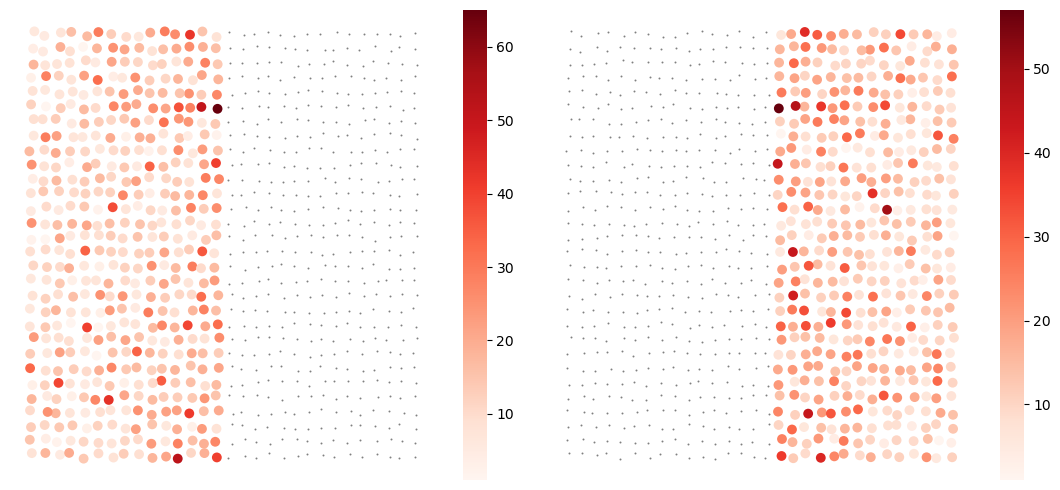

In [556]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, 
                         figsize=(11, 5))

axes[0].scatter(df_tmp.x, df_tmp.y,s=2,alpha=1,linewidth=0,color='grey');
sns.scatterplot(data= tmp_source, x="x", y="y", hue="gene", 
                palette="Reds",  s=50, linewidth=0, alpha=1, ax=axes[0])
norm = plt.Normalize(tmp_source['gene'].min(), tmp_source['gene'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
axes[0].get_legend().remove()
cbar = axes[0].figure.colorbar(sm,ax=axes[0])
cbar.outline.set_linewidth(0)
axes[0].axis('off')

axes[1].scatter(df_tmp.x, df_tmp.y,s=2,alpha=1,linewidth=0,color='grey');
sns.scatterplot(data= tmp_end, x="x", y="y", hue="gene", 
                palette="Reds",  s=50, linewidth=0, alpha=1, ax=axes[1])
norm = plt.Normalize(tmp_end['gene'].min(), tmp_end['gene'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
axes[1].get_legend().remove()
cbar = axes[1].figure.colorbar(sm,ax=axes[1])
cbar.outline.set_linewidth(0)
axes[1].axis('off')

plt.tight_layout()

plt.show()

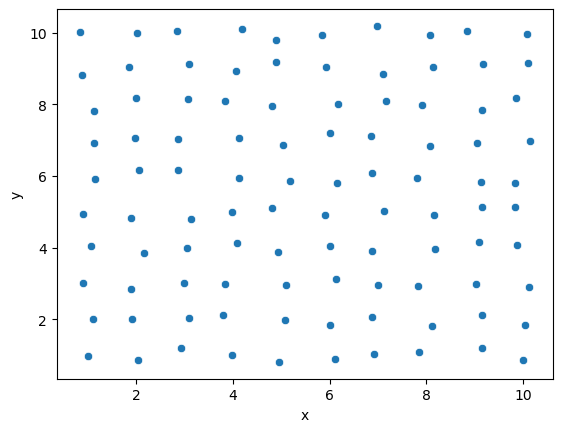

In [366]:
sns.scatterplot(data = df_tmp, x = 'x', y='y');
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pos_w.x, pos_w.y,s=1,alpha=1,linewidth=0,color='grey');
plt.axis('off');

In [400]:
n_neighs = 1

coords = df_tmp[['x', 'y']].values
tree = NearestNeighbors(n_neighbors=n_neighs, radius=0.8, metric="euclidean")
tree.fit(coords)
results = tree.radius_neighbors()
dists = np.concatenate(results[0])
row_indices = np.concatenate(results[1])
col_indices = np.repeat(np.arange(coords.shape[0]), [len(x) for x in results[1]])

In [401]:
Adj = csr_matrix((
    np.ones_like(row_indices, dtype=np.float64), 
    (row_indices, col_indices)), shape=(coords.shape[0], coords.shape[0]))

In [402]:
Dst = csr_matrix((dists, (row_indices, col_indices)), shape=(coords.shape[0], coords.shape[0]))

In [403]:
Dst

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 34 stored elements in Compressed Sparse Row format>

In [404]:
df_tmp.shape

(100, 3)

In [405]:
G = nx.from_scipy_sparse_array(Dst)

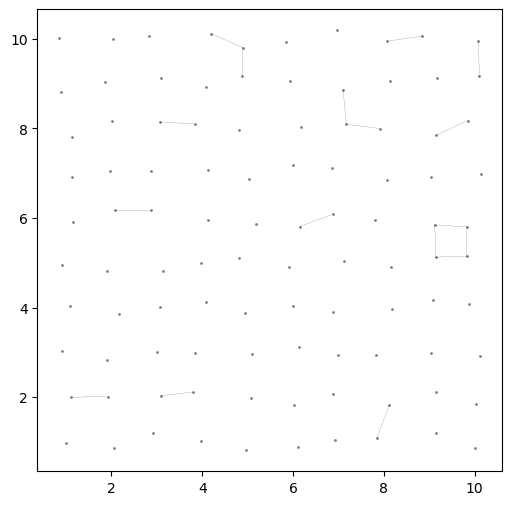

In [406]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(df_tmp['x'], df_tmp['y'], c= "grey", s=1)
for edge in G.edges():
    x1, y1 = df_tmp.iloc[edge[0]].x, df_tmp.iloc[edge[0]].y
    x2, y2 = df_tmp.iloc[edge[1]].x, df_tmp.iloc[edge[1]].y
    ax.plot([x1, x2], [y1, y2], color='black',linewidth = 0.1)

In [567]:
from scipy.sparse import issparse

In [569]:
if issparse:
    print('hello')

hello


In [ ]:
def weight_matrix(adata, l, cutoff=None, n_neighbors=None, n_nearest_neighbors=6, single_cell=False):
    """
    compute weight matrix based on radial basis kernel.
    cutoff & n_neighbors are two alternative options to restrict signaling range.
    :param l: radial basis kernel parameter, need to be customized for optimal weight gradient and \
    to restrain the range of signaling before downstream processing.
    :param cutoff: (for secreted signaling) minimum weight to be kept from the rbf weight matrix. \
    Weight below cutoff will be made zero
    :param n_neighbors: (for secreted signaling) number of neighbors per spot from the rbf weight matrix.
    :param n_nearest_neighbors: (for adjacent signaling) number of neighbors per spot from the rbf \
    weight matrix.
    Non-neighbors will be made 0
    :param single_cell: if single cell resolution, diagonal will be made 0.
    :return: secreted signaling weight matrix: adata.obsp['weight'], \
            and adjacent signaling weight matrix: adata.obsp['nearest_neighbors']
    """
    def _Euclidean_to_RBF(X, l, singlecell=single_cell):
        """Convert Euclidean distance to RBF distance"""
        from scipy.sparse import issparse
        if issparse:
            rbf_d = X
            rbf_d[X.nonzero()] = np.exp(-X[X.nonzero()].A**2 / (2 * l ** 2))
        else:
            rbf_d = np.exp(- X**2 / (2 * l ** 2))
        
        # At single-cell resolution, no within-spot communications
        if singlecell:
            np.fill_diagonal(rbf_d, 0)
        else:
            rbf_d.setdiag(np.exp(-X.diagonal()**2 / (2 * l ** 2)))

        return rbf_d
    
    adata.uns['single_cell'] = single_cell
    if isinstance(adata.obsm['spatial'], pd.DataFrame):
        X_loc = adata.obsm['spatial'].values
    else:
        X_loc = adata.obsm['spatial']

    if n_neighbors is None:
        n_neighbors = n_nearest_neighbors * 31

    ## large neighborhood for W (5 layers)
    nnbrs = NearestNeighbors(
        n_neighbors=n_neighbors,
        algorithm='ball_tree', 
        metric='euclidean'
    ).fit(X_loc)
    nbr_d = nnbrs.kneighbors_graph(X_loc, mode='distance')
    rbf_d = _Euclidean_to_RBF(nbr_d, l, single_cell)

    ## small neighborhood for RBF
    nnbrs0 = NearestNeighbors(
        n_neighbors=n_nearest_neighbors, 
        algorithm='ball_tree', 
        metric='euclidean'
    ).fit(X_loc)
    nbr_d0 = nnbrs0.kneighbors_graph(X_loc, mode='distance')
    rbf_d0 = _Euclidean_to_RBF(nbr_d0, l, single_cell)

    # NOTE: add more info about cutoff, n_neighbors and n_nearest_neighbors
    if cutoff:
        # not efficient
        # rbf_d[rbf_d < cutoff] = 0
        
        # more efficient: 
        # https://seanlaw.github.io/2019/02/27/set-values-in-sparse-matrix/
        nonzero_mask = np.array(rbf_d[rbf_d.nonzero()] < cutoff)[0]
        rows = rbf_d.nonzero()[0][nonzero_mask]
        cols = rbf_d.nonzero()[1][nonzero_mask]
        rbf_d[rows, cols] = 0

    # elif n_neighbors:
    #     nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(rbf_d)
    #     knn = nbrs.kneighbors_graph(rbf_d).toarray()
    #     rbf_d = rbf_d * knn

    adata.obsp['weight'] = rbf_d * adata.shape[0] / rbf_d.sum()
    adata.obsp['nearest_neighbors'] = rbf_d0 * adata.shape[0] / rbf_d0.sum()
    return